<a href="https://colab.research.google.com/github/KordelFranceTech/GoldiloxFund/blob/main/StatArbExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  12 of 12 completed


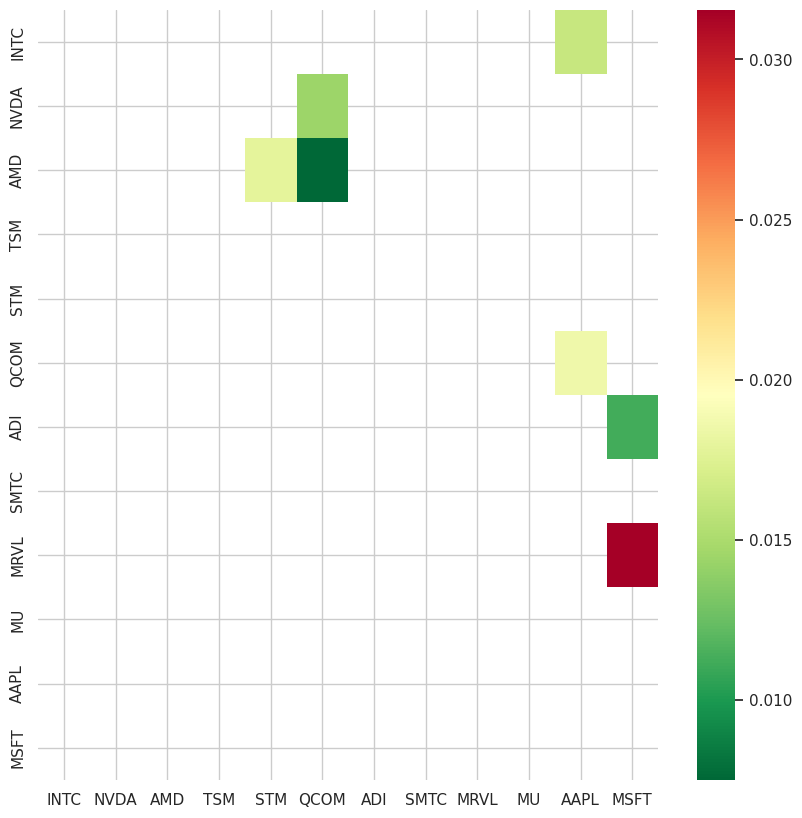


cointegrated pairs:
	[('AAPL', 'STM'), ('ADI', 'MSFT'), ('AMD', 'MRVL'), ('AMD', 'MSFT'), ('MSFT', 'STM'), ('MU', 'TSM'), ('QCOM', 'TSM')]

scores:
	-3.844709795838797
p-values:
	0.011804841003652604


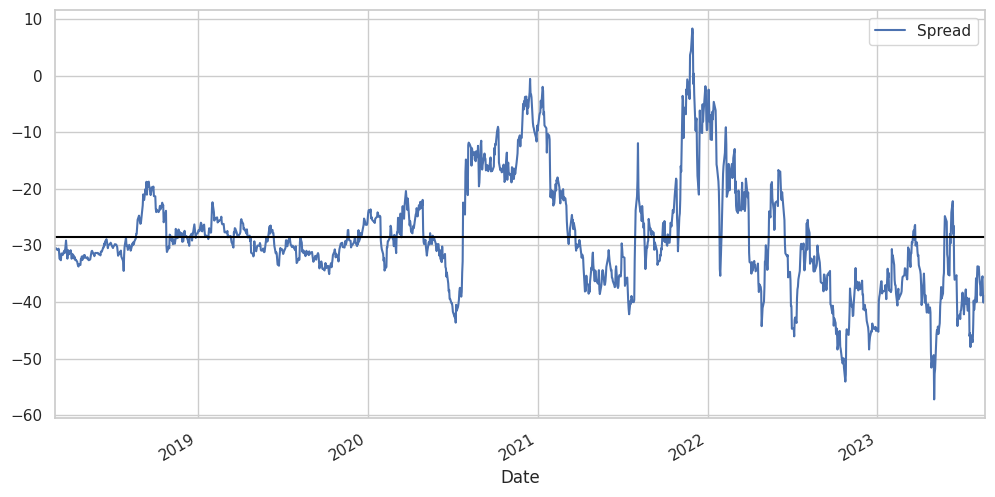

spread:
	Date
2018-02-28   -30.661489
2018-03-01   -30.451849
2018-03-02   -30.633076
2018-03-05   -30.802193
2018-03-06   -30.806231
                ...    
2023-08-14   -35.824988
2023-08-15   -35.460615
2023-08-16   -38.954663
2023-08-17   -40.099083
2023-08-18   -38.906639
Length: 1378, dtype: float64


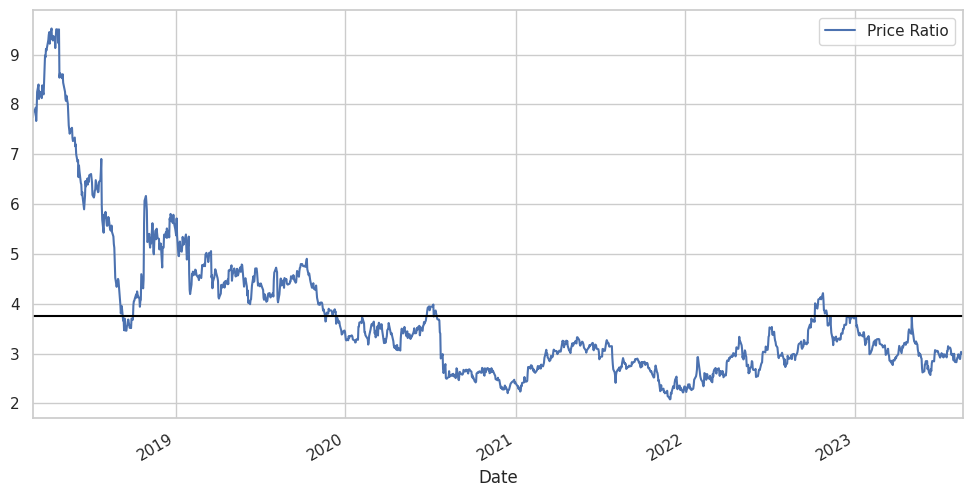

ratios:
	Date
2018-02-28    7.743187
2018-03-01    7.802521
2018-03-02    7.878916
2018-03-05    7.862301
2018-03-06    7.935374
                ...   
2023-08-14    2.893731
2023-08-15    2.890525
2023-08-16    2.989085
2023-08-17    3.034087
2023-08-18    3.001233
Length: 1378, dtype: float64


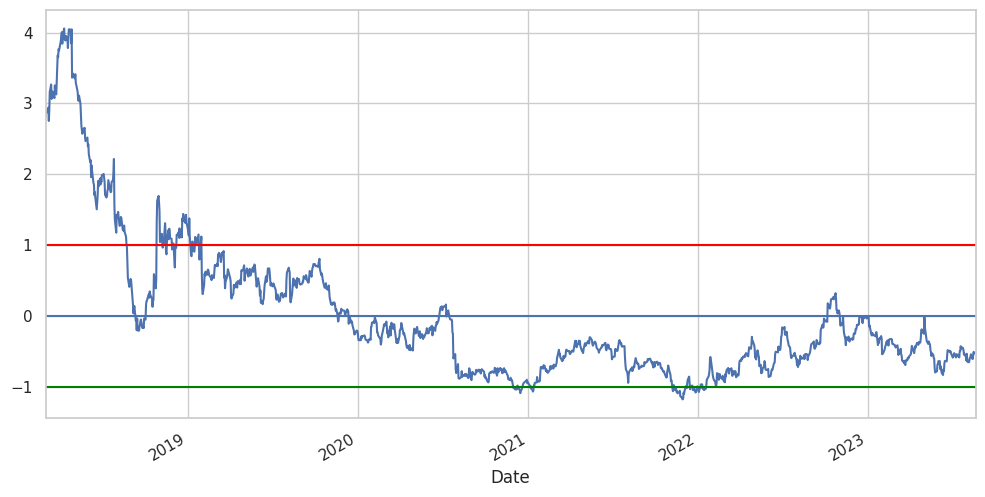

<Figure size 640x480 with 0 Axes>

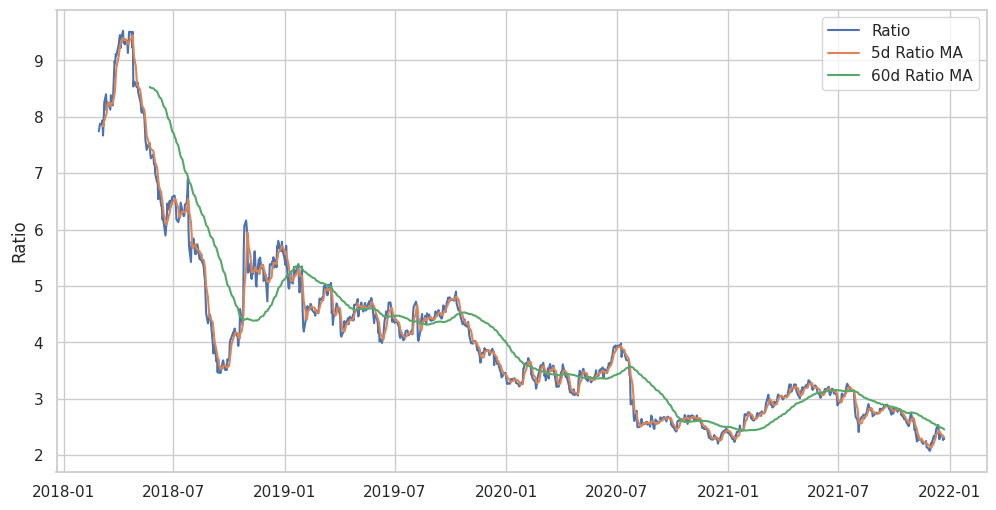

<Figure size 640x480 with 0 Axes>

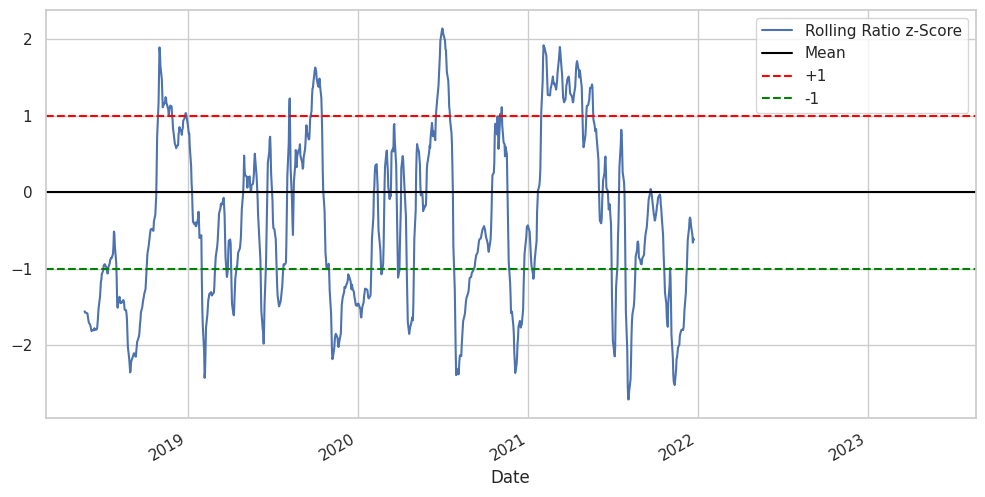

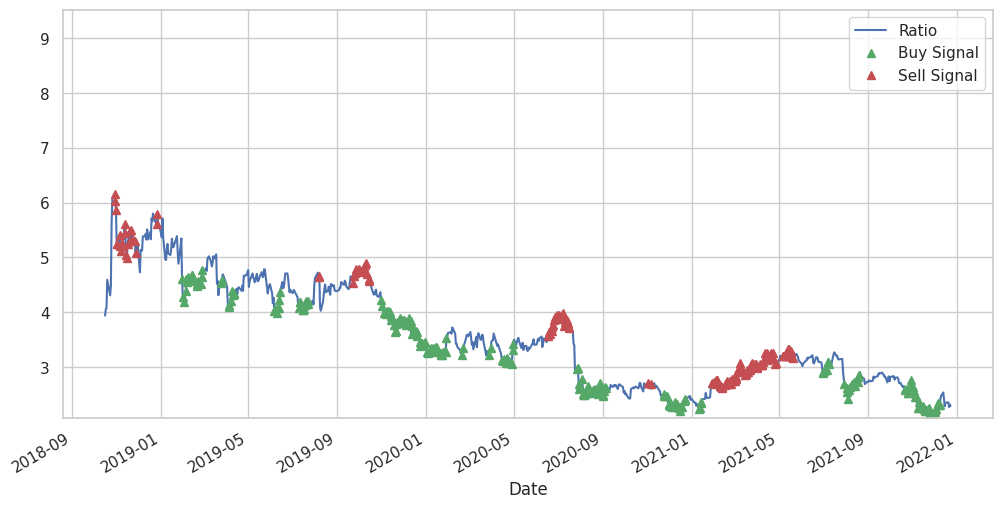

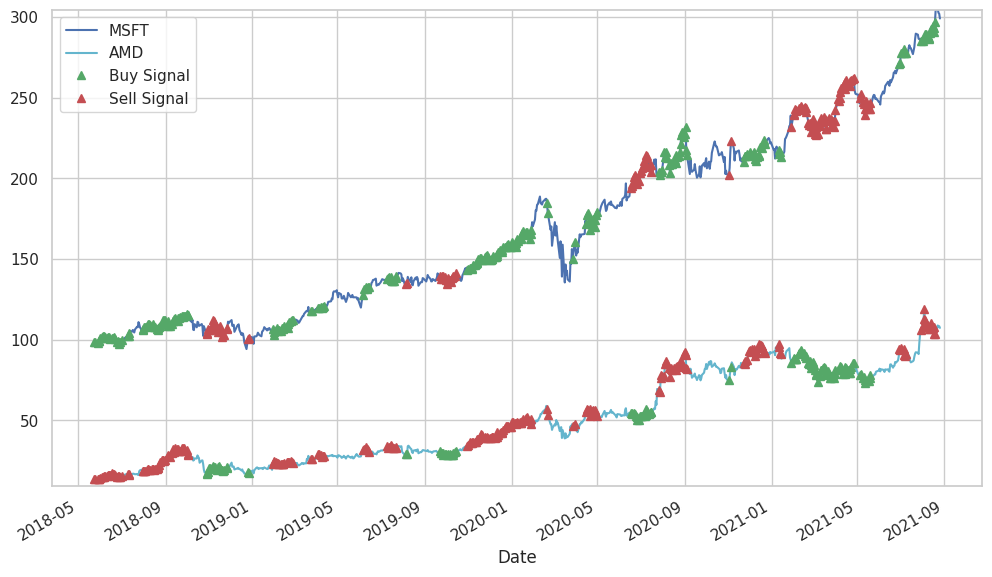


backtest returns from 2018-02-28 00:00:00 to 2023-08-21 00:00:00:
	3717.0226367532896


In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import seaborn
import yfinance as yf
yf.pdr_override()
import datetime


INITIAL_INVEST: float = 10000000.0
CURRENT_SHARES: int = 0
MA_WINDOW_LOW: int = 5
MA_WINDOW_HIGH: int = 60
N_DAYS: int = 2000

Z_SCORE_BUY_RATIO: float = 1.0
Z_SCORE_SELL_RATIO: float = -1.0
Z_SCORE_EXIT_RATIO: float = 0.75
# start_date = datetime.datetime(2013, 1, 1)
# end_date = datetime.datetime(2018, 1, 1)
start_date = datetime.datetime.now() - datetime.timedelta(days=N_DAYS)
start_date = datetime.datetime(start_date.year, start_date.month, start_date.day)
end_date = datetime.datetime(datetime.datetime.today().year, datetime.datetime.today().month, datetime.datetime.today().day)



def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')


def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


def build_pvalue_map(ticker_df, tickers, should_plot=False):
    # Heatmap to show the p-values of the cointegration test between each pair of
    # stocks. Only show the value in the upper-diagonal of the heatmap
    scores, pvalues, pairs = find_cointegrated_pairs(ticker_df)
    fig, ax = plt.subplots(figsize=(10, 10))
    seaborn.heatmap(pvalues,
                xticklabels=tickers,
                yticklabels=tickers,
                cmap='RdYlGn_r',
                mask=(pvalues >= 0.05))
    plt.show()
    return pairs


def test_cointegration(ticker_df, ticker_a, ticker_b):
    S1 = ticker_df[ticker_a]
    S2 = ticker_df[ticker_b]
    score, pvalue, _ = coint(S1, S2)
    return score, pvalue


def calculate_spread(ticker_df, ticker_a, ticker_b, should_plot=False):
    S1 = ticker_df[ticker_a]
    S2 = ticker_df[ticker_b]
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[ticker_a]
    b = results.params[ticker_a]
    spread = S2 - b * S1
    if should_plot:
        plt.clf()
        spread.plot(figsize=(12, 6))
        plt.axhline(spread.mean(), color='black')
        plt.xlim(start_date, end_date)
        plt.legend(['Spread'])
        plt.show()
    return spread


def calculate_ratio(ticker_df, ticker_a, ticker_b, should_plot=False):
    S1 = ticker_df[ticker_a]
    S2 = ticker_df[ticker_b]
    ratio = S1/S2
    if should_plot:
        plt.clf()
        ratio.plot(figsize=(12,6))
        plt.axhline(ratio.mean(), color='black')
        plt.xlim(start_date, end_date)
        plt.legend(['Price Ratio'])
        plt.show()
    return ratio


def calculate_zscore(series, should_plot):
    z = (series - series.mean()) / np.std(series)
    if should_plot:
        plt.clf()
        z.plot(figsize=(12, 6))
        plt.axhline(z.mean())
        plt.axhline(1.0, color='red')
        plt.axhline(-1.0, color='green')
        plt.xlim(start_date, end_date)
        plt.show()
    return z


def build_train_test_split(ticker_df, ticker_a, ticker_b):
    S1 = ticker_df[ticker_a]
    S2 = ticker_df[ticker_b]
    ratios = S1 / S2
    div: int = int(0.7*len(ratios))
    train_set = ratios[:div]
    test_set = ratios[div:]
    return train_set, test_set


def feature_engineer_ratios(train_set, test_set, should_plot_ta=False, should_plot_ratios=False):
    ratios_mavg5 = train_set.rolling(window=5, center=False).mean()
    ratios_mavg60 = train_set.rolling(window=60, center=False).mean()
    std_60 = train_set.rolling(window=60, center=False).std()
    zscore_60_5 = (ratios_mavg5 - ratios_mavg60) / std_60
    if should_plot_ta:
        plt.clf()
        plt.figure(figsize=(12, 6))
        plt.plot(train_set.index, train_set.values)
        plt.plot(ratios_mavg5.index, ratios_mavg5.values)
        plt.plot(ratios_mavg60.index, ratios_mavg60.values)
        plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
        plt.ylabel('Ratio')
        plt.show()
    if should_plot_ratios:
        plt.clf()
        plt.figure(figsize=(12, 6))
        zscore_60_5.plot()
        plt.xlim(start_date, end_date)
        plt.axhline(0, color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
        plt.show()
    return zscore_60_5


def create_buy_sell_signals(train_set, feature_df, should_plot=False):
    plt.figure(figsize=(12, 6))
    train_set[160:].plot()
    buy = train_set.copy()
    sell = train_set.copy()
    buy[feature_df > -1] = 0
    sell[feature_df < 1] = 0

    if should_plot:
        buy[160:].plot(color='g', linestyle='None', marker='^')
        sell[160:].plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, ratios.min(), ratios.max()))
        # plt.xlim('2013-08-15', '2016-07-07')
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()
    return buy, sell


def create_ratio_signals(ticker_df, ticker_a, ticker_b, buy, sell, should_plot):
    plt.figure(figsize=(12, 7))
    S1 = ticker_df[ticker_a].iloc[:881]
    S2 = ticker_df[ticker_b].iloc[:881]

    S1[60:].plot(color='b')
    S2[60:].plot(color='c')
    buyR = 0 * S1.copy()
    sellR = 0 * S1.copy()

    # When you buy the ratio, you buy stock S1 and sell S2
    buyR[buy != 0] = S1[buy != 0]
    sellR[buy != 0] = S2[buy != 0]

    # When you sell the ratio, you sell stock S1 and buy S2
    buyR[sell != 0] = S2[sell != 0]
    sellR[sell != 0] = S1[sell != 0]

    if should_plot:
        buyR[60:].plot(color='g', linestyle='None', marker='^')
        sellR[60:].plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
        # plt.ylim(0, 500)
        # plt.xlim('2013-03-22', '2016-07-04')

        plt.legend([ticker_a, ticker_b, 'Buy Signal', 'Sell Signal'])
        plt.show()


# Trade using a simple strategy
def backtest_stat_arb_v1(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    return money


def backtest_stat_arb_v2(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    cash: float = INITIAL_INVEST
    current_shares: float = CURRENT_SHARES
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        share_price = S1[i]
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            cash += float(S1[i] - S2[i] * ratios[i])
            countS1 -= 1
            countS2 += ratios[i]
            current_shares -= (cash / share_price)
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            cash -= float(S1[i] - S2[i] * ratios[i])
            countS1 += 1
            countS2 -= ratios[i]
            current_shares += (cash / share_price)
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            cash += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            current_shares -= (cash / share_price)
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    return cash


if __name__ == "__main__":
    ticker_a: str = "MSFT"
    ticker_b: str = "AMD"
    # tickers: list = [ticker_a, ticker_b]
    # tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY', 'NVDA']
    tickers: list = ['INTC',
                     'NVDA',
                     'AMD',
                     'TSM',
                     'STM',
                     'QCOM',
                     'ADI',
                     'SMTC',
                     'MRVL',
                     'MU',
                     'AAPL',
                     'MSFT']
    df = pdr.get_data_yahoo(tickers, start_date, end_date)['Close']
    df.tail()

    pairs = build_pvalue_map(df, tickers, should_plot=True)
    print(f"\ncointegrated pairs:\n\t{pairs}")
    scores, pvalues = test_cointegration(df, ticker_a, ticker_b)
    print(f"\nscores:\n\t{scores}\np-values:\n\t{pvalues}")
    spread = calculate_spread(df, ticker_a, ticker_b, True)
    print(f"spread:\n\t{spread}")
    ratios = calculate_ratio(df, ticker_a, ticker_b, True)
    print(f"ratios:\n\t{ratios}")
    zscores = calculate_zscore(ratios, True)
    train_set, test_set = build_train_test_split(df, ticker_a, ticker_b)
    feature_df = feature_engineer_ratios(train_set, test_set, True, True)
    buy_signals, sell_signals = create_buy_sell_signals(train_set, feature_df, should_plot=True)
    create_ratio_signals(df, ticker_a, ticker_b, buy_signals, sell_signals, should_plot=True)
    backtest_returns = backtest_stat_arb_v1(df[ticker_a].iloc[881:], df[ticker_b].iloc[881:], 60, 5)
    print(f"\nbacktest returns from {start_date} to {end_date}:\n\t{backtest_returns}")
